# Reinforcment Learning

In [14]:
#provides the basic imports and environment to use as well as print the initial state
import gym
env = gym.make("Taxi-v3").env
# the printing method
print("=== Initial State ===")
env.render()

=== Initial State ===
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [16]:
# will reset the environment to a new state and print out what the state looks like
env.reset()
env.render()

# this prints out the action space, (which action it takes north, south ect ect) 
# actions would be 0 = south, 1 = north, 2 = east, 3 = west, 4 = pick-up, 5 = dropoff. this is between 0-5 so actionspace is 6
# and the state space, which state of the 500 possible states it can be in
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


In [18]:
# this sets the state of the current taxi based on the (row, column, position, destination)
state = env.encode(3, 1, 2, 0)
# prints the state
print("State:", state)

# sets the environment state to the state value and renders it
env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [20]:
# basic reward table to showcase whats happening
# as can be seen every position has a state and the boolean value details whether it has finished. 
# this is a dictionary using the format action:(probability, next state, reward, done)
# pick up or drop off is the worst possible reward as there is no passenger in the taxi or in the road
# the rest are simple moves, better to go towards a position than to stay still
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

In [22]:
# sets the environment to the state
env.s = 328
epochs = 0
penalties, reward = 0, 0
# used for animations not really necessary in this case
frames = []
# whether the sequence is finished
done = False
# while loop for the overall actions and states so the machine can slowly learn what its doing
while not done:
    # set a possible action
    action = env.action_space.sample()
    # set the variables basde on the aquired actions
    state, reward, done, info = env.step(action)
    # checks if the action is the worst possible one
    if reward == -10:
        penalties += 1
    # Put each rendered frame into dict for animation
    # again not quite necessarry for the overall idea but a useful one
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    epochs += 1  
# prints based on the steps taken and how many penalties from making the best move, because
# regardless the amchine takes some penalties form its moves.
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 5670
Penalties incurred: 1834


# Q-Learning in Taxi Problem

In [24]:
# starting setup to determine the overall numpy value adn the q-table for the q-value
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [28]:
%%time
"""Training the agent"""
#uses the random and Ipython 
import random
from IPython.display import clear_output

alpha = 0.1
gamma = 0.6
epsilon = 0.1
# plotting the matrix 
all_epochs = []
all_penalties = []

# the maximum aount is 100000 whereas the minimum episode is 1, loop to rin through everything
for i in range(1, 100001):
    state = env.reset()
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    # while this loop is not finished the computer will explore random actions or exploit the best outcome based on learned values
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])
            
        #sets the next step values
        next_state, reward, done, info = env.step(action) 
        
        #starts and prepares the overall solve for the q-value
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        # uses the next value by checking what it is and applying it to the prior value
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        # sets the penalties for actions made
        if reward == -10:
            penalties += 1

        # sets the state to the next_state
        state = next_state
        epochs += 1
        
    # if loop does not leave a remainder of 0 clear iputut and set wait
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")


Episode: 100000
Training finished.

Wall time: 1min


In [30]:
# showcases what the q-value looks like now
# the closer value to 0 the better the actual decision is
q_table[328]

array([ -2.41269506,  -2.27325184,  -2.41722775,  -2.3616033 ,
       -11.09542391, -11.21985096])

In [32]:
"""Evaluate agent's performance after Q-learning"""

# checks the overall penalties and ferformance of the agent
total_epochs, total_penalties = 0, 0
# based on 100 episodes 
episodes = 100

# loops all in range within epsiodes, 100, and sets the state for done
for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False
    
    # while not finished will set the variables based on the actions generated
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    # prepares the print valeus
    total_penalties += penalties
    total_epochs += epochs

    #prints the values as well as the format it appears in
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 13.23
Average penalties per episode: 0.0


# Q-Learning in Cart-Pole Problem

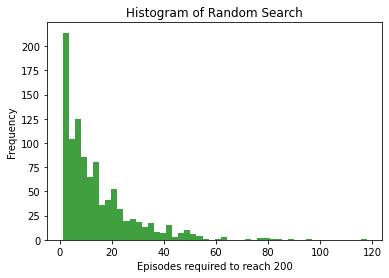

14.185


In [68]:
# set the import libraries
import gym
import numpy as np
import matplotlib.pyplot as plt

# method for running the overall episodes
def run_episode(env, parameters):
    observation = env.reset()
    totalreward = 0
    # does this 200 times
    for _ in range(200):
        # sets the action to 0 if the parameter observation output is less than 0, otherwise its 1
        action = 0 if np.matmul(parameters,observation) < 0 else 1
        # sets the observation, reward, done, infor variable to the created environment.step
        observation, reward, done, info = env.step(action)
        # adds to a total reward based on the valid steps taken
        totalreward += reward
        #breaks the loop if complete
        if done:
            break
    # returns the reward
    return totalreward

# this is the overall training method
def train(submit):
    # will set invironment to the carpole gym 
    env = gym.make('CartPole-v0')
    # if values have been submitted and the sumbitted values are valid
    if submit:
        # will start to monitor and check the cartpole actions 
        env.monitor.start('cartpole-experiments/', force=True)

    # setting counter, bestparams, bestreward
    counter = 0
    bestparams = None
    bestreward = 0
    # loops to 10000 tiems 
    for _ in range(10000):
        # adding a counter each time
        counter += 1
        # sets the parameters to a random number from 0-3 and multiplying it by 2 - 1
        parameters = np.random.rand(4) * 2 - 1
        # sets reward to the returned epsiode value i.e what it gets for the steps
        reward = run_episode(env,parameters)
        # will pick the best reward from the actions taken
        if reward > bestreward:
            bestreward = reward
            bestparams = parameters
            if reward == 200:
                break
    # if submitted than loops the epsidoe 100 times and closes the monitor
    if submit:
        for _ in xrange(100):
            run_episode(env,bestparams)
        env.monitor.close()
    # returns the counter value representing the amount of times something happens
    return counter

# train an agent to submit to openai gym
# train(submit=True)

# create graphs
results = []
for _ in range(1000):
    results.append(train(submit=False))

# sets the plot values nad what the laabels will be like, had to remove hist = 1 as it broke the overall code
# also had to change x_range in the loops to range("value") as this may have been an older codeing method
plt.hist(results,50, facecolor='g', alpha=0.75)
plt.xlabel('Episodes required to reach 200')
plt.ylabel('Frequency')
plt.title('Histogram of Random Search')
plt.show()

#prints the results scaled down
print (np.sum(results) / 1000.0)

2000


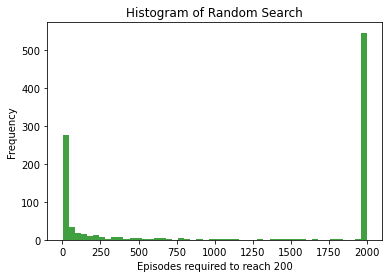

1172.485


In [70]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# returns the total reward from the actions taken
def run_episode(env, parameters):
    # sets the observation to the environments current state
    observation = env.reset()
    # prepares totalreward and counter
    totalreward = 0
    counter = 0
    # loops to check the actions that can be taken and the rewards that are returned
    for _ in range(200):
        # env.render()
        # action if parameters and observations are met, returns 0 or 1
        action = 0 if np.matmul(parameters,observation) < 0 else 1
        # sets the variables to the steps overall outcome
        observation, reward, done, info = env.step(action)
        # sets total reward to reward after all calculations
        totalreward += reward
        # sets the amount of steps as coutner
        counter += 1
        # Break if finished 
        if done:
            break
    return totalreward

# sets the trainign method focusing on teaching the machine
def train(submit):
    env = gym.make('CartPole-v0')
    if submit:
        env.monitor.start('cartpole-hill/', force=True)

    # sets the amount of episodes per update
    episodes_per_update = 5
    # sets the noise scaling value
    noise_scaling = 0.1
    # sets the parameters ot the 0-3 * 2 - 1 value
    parameters = np.random.rand(4) * 2 - 1
    # prepares bestreward and counter
    bestreward = 0
    counter = 0

    # loops a range to 2000
    for _ in range(2000):
        # adds counter
        counter += 1
        # newparams is set to the parameters and a random value with noise scaling
        newparams = parameters + (np.random.rand(4) * 2 - 1)*noise_scaling
        # sets reward to the returned total reward of run-episode
        reward = run_episode(env,newparams)
        # if the reward is greater thna the best reward than replce it with the new rwards
        if reward > bestreward:
            bestreward = reward
            parameters = newparams
            if reward == 200:
                break

    # if submitted will run a loop 100 times for the episode and the monitor will cloese
    # returns the counter
    if submit:
        for _ in range(100):
            run_episode(env,parameters)
        env.monitor.close()
    return counter


# prints the amount of runs to get the overall preferred state
r = train(submit=False)
print (r)

# create graphs
results = []
for _ in range(1000):
    results.append(train(submit=False))

# sets the plot values nad what the laabels will be like, had to remove hist = 1 as it broke the overall code
# also had to change x_range in the loops to range("value") as this may have been an older codeing method
plt.hist(results,50, facecolor='g', alpha=0.75)
plt.xlabel('Episodes required to reach 200')
plt.ylabel('Frequency')
plt.title('Histogram of Random Search')
plt.show()

#prints the results scaled down
print (np.sum(results) / 1000.0)